## <center> INTRACRANIAL HEMORRHAGES DATABASE - KERNEL METHODS - SVM & SSVM</center>

**Kernel methods** are a type of Machine Learning algorithms used to map input data into a different multidimensional space in which data classes can be easily sepparated. Therefore, this methods are very used to solve classifcation and regression problems. A very well-knowned algorithm of this group is **Support Vector Machine (SVM)**, which has been adapted for solving survival prediction in the named **Survival Support Vector Machine (SSVM)**.

**1. Load dataset**


**2. Support Vector Machine (SVM)**

- **Data pre-processing**
- **Fitting**
    - SVM for survival_discharge
    - SVM for follow_up
    - SVM for final_outcome
- **Testing**


**3. Survival Support Vector Machine (SSVM)**

- **Data pre-processing**
- **Linear SSVM**

    - Ranking objective
    - Regression objective
- **Kernel SSVM**

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sksurv.util import Surv
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from time import time

### Silent warnings and Set decimal notation

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True) # Print decimal notation instead of scientific notation

### 1. Load dataset

In [3]:
df= pd.read_hdf('Databases/ICH_database.hdf5')
df_metadata= pd.read_csv('Databases/ICH_database_metadata.csv')
df.head(4)

,patient,sex,hospital,follow_up,final_outcome,nfamily_medhist,tobacco,n_tobacco,drugs,alcohol,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,time_between_CT_bloodanalysis,age,survival_days
0,1,1,1.0,2.0,2.0,17,2.0,NaN,0,0,...,17.0,33.0,9.0,28.1,4.21,344.0,618.0,0,74,4
1,2,2,2.0,0.0,1.0,4,0.0,0.0,0,0,...,14.7,32.5,10.7,29.8,NaN,NaN,1081.0,0,81,2128
2,3,2,1.0,0.0,0.0,8,0.0,0.0,0,0,...,14.0,33.1,8.7,30.1,3.16,298.0,470.0,0,78,2388
3,4,2,1.0,2.0,2.0,8,0.0,0.0,0,0,...,15.8,34.1,7.6,19.3,1.09,344.0,344.0,0,79,7


In [4]:
# Explore outcomes (hospitalization days will be considered as a predictor)
outcomes= df_metadata[df_metadata['Type_of_Variable'] == 'Outcome']['Variable_Label'].values.tolist()
outcomes

['follow_up',
 'final_outcome',
 'survival_discharge',
 'survival_3d',
 'survival_6d',
 'survival_9d',
 'survival_12d',
 'survival_15d',
 'survival_1m',
 'survival_3m',
 'survival_1y',
 'survival_5y',
 'survived',
 'neurosurg',
 'interprocedures',
 'survival_days']

In [5]:
# Selection of some predictors to have enought sample after removing NaNs
predictors= ['sex','nfamily_medhist', 'ht', 'dmellitus', 'dyslipidemia', 'structural_heart_disease',
             'neurological_diseases',
             'antihypertensives', 'antidiabetics', 'hypolipidemics', 'anticoagulants', 'antiplatelets',
             'aspirin', 'cumarinics',
             'headache', 'emesis', 'visual_disturbances', 'seizures',
             'neurol_signs', 'anisocoria', 'altered_consciousness',
             'ruplimb_mimpairment', 'luplimb_mimpairment', 'rlwlimb_mimpairment', 'llwlimb_mimpairment',
             'balance_impairment', 'tgcs', 'onset_h',
             'primary_ich',
             'glucose', 'urea', 'creatinine', 'potasium', 'prothrombin_activity', 'hematocrit', 'maxfibrinogen',
             'age']

In [6]:
df_X= df[predictors]
df_y= df[outcomes]

### 2. Support Vector Machine (SVM)

- **Data pre-processing**

- **Fitting**
    - **SVM for survival_discharge**
    - **SVM for follow_up**
    - **SVM for final_outcome**

- **Testing**

**Support Vector Machines (SVMs)** are one of the most popular Machine Learning models used to solve classification and regression problems. These models find a hyperplane able to separate classes in a multidimensional space, so when a new sample has to be classify, it is enought to represent it and see in which side of the hyperplane falls.

**SVMs are unable to be applied directly to categorical data**, since they are based on the *euclidean distances*. These methods are usually applied to **continuous numerical data**. However, using **dummy variables** to represent the categorical data and **standarizing the numerical variables**, contributions to the euclidean distances from a numerical variable and a categorical variable are basically on the same level, so **SVM can be applied**. Finally, techniques such as **PCA** usually improve the performance of these three classifiers significantly.

#### 2.1. Data pre-processing

In [7]:
# Standarization of the variables to avoid scale problems
scaler= StandardScaler()

# Separete quantitatives and qualitatives
quantitatives= [variable for variable in df_X.columns.tolist() if df_X[variable].dtype in ('int64','float64')]
df_X_quant= df_X[quantitatives]
df_X_qual= df_X[list(set(df_X.columns.tolist()) - set(quantitatives))]

# Standarize quantitatives
X_quant_std= scaler.fit_transform(df_X_quant)
df_X_quant_std= pd.DataFrame(data=X_quant_std, columns=df_X_quant.columns.to_list())

# Concatenate quantitatives standarized and qualitatives
df_X_std= pd.concat([df_X_quant_std, df_X_qual], axis=1)

# Remove NaN
df_X_std_nonan= df_X_std.dropna(axis=0)
df_X_std_nonan.shape

(129, 37)

In [8]:
# Prepare data and labels
data= df_X_std_nonan

y1= df_y.loc[data.index, 'survival_discharge'] # Death (0) vs survival (1)
y2= df_y.loc[data.index, 'follow_up'] # No deterioration (0) vs deterioration (1) vs death (2)
y3= df_y.loc[data.index, 'final_outcome'] # Curation (0,1) vs death (2)

idx1= (y1 == 0) | (y1 == 1)
idx2= (y2 == 0) | (y2 == 1) | (y2 == 2)
idx3= (y3 == 0) | (y3 == 1) | (y3 == 2)

x_data1= df_X_std_nonan[idx1]
x_data2= df_X_std_nonan[idx2]
x_data3= df_X_std_nonan[idx3]

y_data1= pd.Categorical(y1[idx1]).remove_unused_categories()
y_data2= pd.Categorical(y2[idx2]).remove_unused_categories()
y3[y3 == 1]= 0; y3[y3 == 2]= 1
y_data3= pd.Categorical(y3[idx3]).remove_unused_categories()

print(np.asarray(np.unique(y_data1, return_counts=True)).T, '\n')
print(np.asarray(np.unique(y_data2, return_counts=True)).T, '\n')
print(np.asarray(np.unique(y_data3, return_counts=True)).T, '\n')

[[ 0 31]
 [ 1 98]] 

[[ 0. 57.]
 [ 1. 34.]
 [ 2. 33.]] 

[[ 0. 91.]
 [ 1. 30.]] 



In [9]:
# Separar en 2/3 para entrenar y 1/3 para testar
X_train1, X_test1, y_train1, y_test1= train_test_split(x_data1, y_data1, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2= train_test_split(x_data2, y_data2, test_size=0.2, random_state=0)
X_train3, X_test3, y_train3, y_test3= train_test_split(x_data3, y_data3, test_size=0.2, random_state=0)

print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

(103, 37)
(103,)
(26, 37)
(26,)


#### 2.2. Fitting

In [10]:
# Make a pipeline and a GridSearch to find the best hyperparameters

pca= PCA(whiten=True, svd_solver='randomized', random_state=0)
svc= SVC(class_weight='balanced')
svc_pipe= make_pipeline(pca, svc)

param_grid= {'pca__n_components': [8, 10, 12, 16, 17, 18, 20],
             'svc__C': [0.5, 1, 2, 3, 4],
             'svc__kernel': ['rbf', 'linear'],
             'svc__gamma': [0.001, 0.005, 0.05, 0.1, 0.5]}

cv= KFold(n_splits=5, shuffle=True, random_state=0)

gcv= GridSearchCV(estimator=svc_pipe,
                  param_grid=param_grid,
                  cv=cv,
                  error_score=0.5,
                  n_jobs=1)

#### 2.2.1. SVM for survival_discharge

In [11]:
t0= time()
gcv1= gcv
gcv1.fit(X_train1, y_train1)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gcv1.best_params_, '\n')
print('Best score:', round(gcv1.best_score_,4))

Fitting time: 0.77 min 

Best hyperparameters:
{'pca__n_components': 17, 'svc__C': 3, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'} 

Best score: 0.8143


In [12]:
# Final model 1 - survival discharge
model1= gcv1.best_estimator_
model1

Pipeline(steps=[('pca',
                 PCA(n_components=17, random_state=0, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(C=3, class_weight='balanced', gamma=0.1))])

#### 2.2.2. SVM for follow_up

In [13]:
t0= time()
gcv2= gcv
gcv2.fit(X_train2, y_train2)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gcv2.best_params_, '\n')
print('Best score:', round(gcv2.best_score_,4))

Fitting time: 0.73 min 

Best hyperparameters:
{'pca__n_components': 10, 'svc__C': 3, 'svc__gamma': 0.005, 'svc__kernel': 'rbf'} 

Best score: 0.6563


In [14]:
# Final model 2 - follow_up
model2= gcv2.best_estimator_
model2

Pipeline(steps=[('pca',
                 PCA(n_components=10, random_state=0, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(C=3, class_weight='balanced', gamma=0.005))])

#### 2.2.3. SVM for final_outcome

In [15]:
t0= time()
gcv3= gcv
gcv3.fit(X_train3, y_train3)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gcv3.best_params_, '\n')
print('Best score:', round(gcv3.best_score_,4))

Fitting time: 0.68 min 

Best hyperparameters:
{'pca__n_components': 18, 'svc__C': 3, 'svc__gamma': 0.05, 'svc__kernel': 'rbf'} 

Best score: 0.8226


In [16]:
# Final model 3 - final_outcome
model3= gcv3.best_estimator_
model3

Pipeline(steps=[('pca',
                 PCA(n_components=18, random_state=0, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(C=3, class_weight='balanced', gamma=0.05))])

#### 2.3. Testing

In [17]:
# Compute test classification metrics

# Model 1 - survival discharge 
y_pred1= model1.predict(X_test1)
print('Model1 \n', classification_report(y_test1, y_pred1, target_names=['Death', 'Survival']), '\n')

# Model 2 - follow_up
y_pred2= model2.predict(X_test2)
print('Model2 \n', classification_report(y_test2, y_pred2, target_names=['No deterioration', 'Deterioration', 'Death']), '\n \n')

# Model 3 - final_outcome 
y_pred3= model3.predict(X_test3)
print('Model3 \n', classification_report(y_test3, y_pred3, target_names=['Curation', 'Death']), '\n \n')

Model1 
               precision    recall  f1-score   support

       Death       0.33      0.14      0.20         7
    Survival       0.74      0.89      0.81        19

    accuracy                           0.69        26
   macro avg       0.54      0.52      0.50        26
weighted avg       0.63      0.69      0.65        26
 

Model2 
                   precision    recall  f1-score   support

No deterioration       0.64      0.78      0.70         9
   Deterioration       0.45      0.71      0.56         7
           Death       0.67      0.22      0.33         9

        accuracy                           0.56        25
       macro avg       0.59      0.57      0.53        25
    weighted avg       0.60      0.56      0.53        25
 
 

Model3 
               precision    recall  f1-score   support

    Curation       0.78      0.70      0.74        20
       Death       0.14      0.20      0.17         5

    accuracy                           0.60        25
   macro avg 

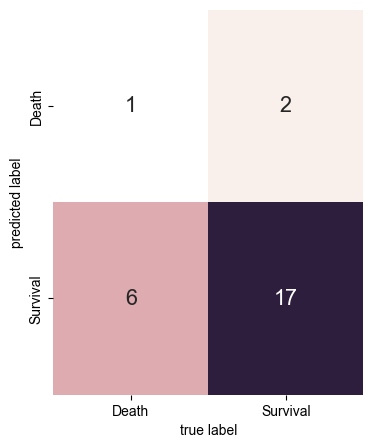

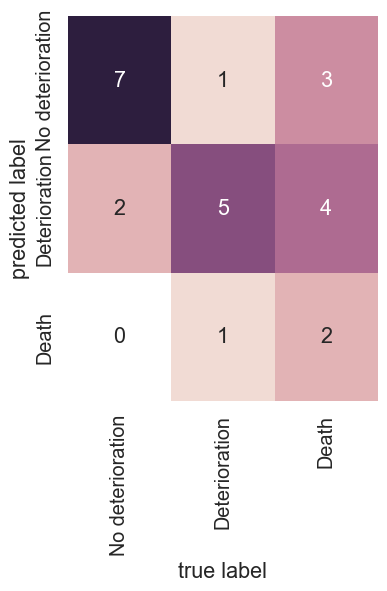

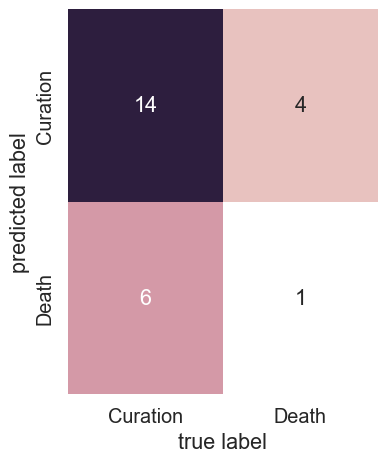

In [18]:
# Hallar la matrix de confusión
conf_matrix1= confusion_matrix(y_test1, y_pred1)
conf_matrix2= confusion_matrix(y_test2, y_pred2)
conf_matrix3= confusion_matrix(y_test3, y_pred3)

def plot_conf_matrix (conf_matrix, names):
    fig, ax = plt.subplots(figsize=(4,5))
    sns.set(font_scale=1.3)
    sns.heatmap(conf_matrix.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=names,
            yticklabels=names,
            cmap=sns.cubehelix_palette(light=1, as_cmap=True))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    
plot_conf_matrix (conf_matrix1, ['Death', 'Survival'])
plot_conf_matrix (conf_matrix2, ['No deterioration', 'Deterioration', 'Death'])
plot_conf_matrix (conf_matrix3, ['Curation', 'Death'])

In [19]:
# Bootstrapping confidence intervals

def boots_svm (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_accuracy= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        pca= PCA(whiten=True, svd_solver='randomized', random_state=0)
        svc= SVC(class_weight='balanced')
        svc_pipe= make_pipeline(pca, svc)
        svc_pipe.set_params(**params_)
        
        svc_pipe.fit(x.values[idx_train,], y[idx_train])
        
        accuracy= svc_pipe.score(x.values[idx_test], y[idx_test])
        test_accuracy.append(accuracy)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    accuracy_median= np.median(test_accuracy)
    accuracy_lower= max(0.0, np.percentile(test_accuracy, pl))
    accuracy_upper= min(1.0, np.percentile(test_accuracy, pu))
    
    return (test_accuracy, (accuracy_median,accuracy_lower,accuracy_upper))

In [20]:
model1_accuracy, model1_ci= boots_svm (x=x_data1, y=y_data1, train_size=0.8, params_=gcv1.best_params_, n_iterations=10000, alpha=0.05)
model2_accuracy, model2_ci= boots_svm (x=x_data2, y=y_data2, train_size=0.8, params_=gcv2.best_params_, n_iterations=10000, alpha=0.05)
model3_accuracy, model3_ci= boots_svm (x=x_data3, y=y_data3, train_size=0.8, params_=gcv3.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Model3: 0.73, 95%CI 0.63 and 0.83')

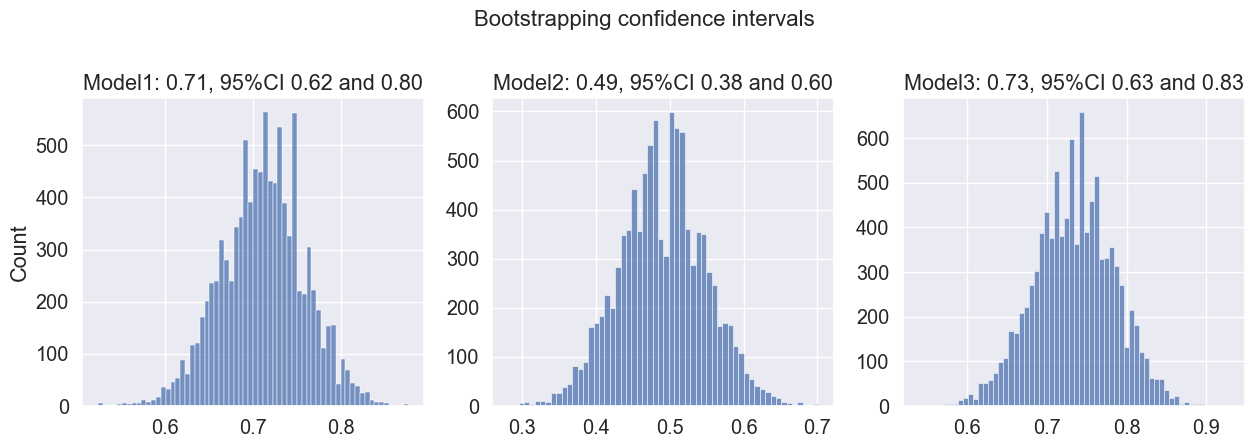

In [21]:
fig, axs= plt.subplots(1,3, figsize=(15,4))
fig.suptitle('Bootstrapping confidence intervals', y=1.1, size=16)

sns.histplot(model1_accuracy, ax=axs[0])
sns.histplot(model2_accuracy, ax=axs[1])
sns.histplot(model3_accuracy, ax=axs[2])

axs[1].set_ylabel('')
axs[2].set_ylabel('')

alpha= 0.05
axs[0].set_title('Model1: %.2f, %.0f%%CI %.2f and %.2f' % (model1_ci[0], (1-alpha)*100, model1_ci[1], model1_ci[2]))
axs[1].set_title('Model2: %.2f, %.0f%%CI %.2f and %.2f' % (model2_ci[0], (1-alpha)*100, model2_ci[1], model2_ci[2]))
axs[2].set_title('Model3: %.2f, %.0f%%CI %.2f and %.2f' % (model3_ci[0], (1-alpha)*100, model3_ci[1], model3_ci[2]))

### 3. Survival Support Vector Machine (SSVM)

- **Data pre-processing**


- **Linear SSVM**

    - **Ranking objective**
        - Fitting
        - Testing
        - Predicting
    
    - **Regression objective**
        - Fitting
        - Testing
        - Predicting
        
        
- **Kernel SSVM**
    - Fitting
    - Testing
    - Predicting

*Text from [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/user_guide/survival-svm.html)*

**Survival Support Vector Machines (SSVM)** are extensions of the standard SVM to censored time-to-event data. 
SSVM can account for complex, non-linear relationships between features and survival via the so-called kernel trick. A kernel function implicitly maps the input features into high-dimensional feature spaces where survival can be described by a hyperplane. This makes SSVM extremely versatile and applicable to a wide a range of data.

Survival analysis in the context of Support Vector Machines can be described in two different ways:

- As a **ranking problem**: the model learns to assign samples with shorter survival times a lower rank by considering all possible pairs of samples in the training data.
- As a **regression problem**: the model learns to directly predict the (log) survival time.

In both cases, the disadvantage is that predictions cannot be easily related to standard quantities in survival analysis, namely survival function and cumulative hazard function. Moreover, they have to **retain a copy** of the training data to do predictions.

### 3.1. Data pre-processing

In [22]:
# Define survival variables
Status= np.array(df_y['survival_discharge'] == 0) # old value 0 (death), is changed for new value True or 1 (death)
Survival_in_days= np.array(df_y['survival_days'])

In [23]:
y= Surv().from_arrays(event=Status, time=Survival_in_days, name_event='Status', name_time='Survival_in_days')

In [24]:
# Check censors
n_censored = y.shape[0] - y['Status'].sum()
print('%.1f%% of records are censored' % (n_censored / y.shape[0] * 100))

69.7% of records are censored


In [25]:
# Standarization of quantitative data
scaler= StandardScaler()

# Separete quantitatives and qualitatives
quantitatives= [variable for variable in df_X.columns.tolist() if df_X[variable].dtype in ('int64','float64')]
df_X_quant= df_X[quantitatives]
df_X_qual= df_X[list(set(df_X.columns.tolist()) - set(quantitatives))]

# Standarize quantitatives
X_quant_std= scaler.fit_transform(df_X_quant)
df_X_quant_std= pd.DataFrame(data=X_quant_std, columns=df_X_quant.columns.to_list())

# Concatenate quantitatives standarized and qualitatives
df_X_std= pd.concat([df_X_quant_std, df_X_qual], axis=1)

# Remove NaN
df_X_std_nonan= df_X_std.dropna(axis=0)
df_X_std_nonan.shape

(129, 37)

In [26]:
y_nonan= y[df_X_std_nonan.index]

In [27]:
# Convert data to numeric
#df_numeric= df_X_std_nonan.apply(pd.to_numeric)

### 3.2. Linear SSVM

- **Ranking objective**
    - **Fitting**
    - **Testing**
    - **Prediction**
    
- **Regression objective**
    - **Fitting**
    - **Testing**
    - **Prediction**

SSVM can be trained with two objectives, ranking or regression. This is fixed as a hyperparameter. Linear SSVM have two important hyperparameters:
- **$\alpha$**: amount of regularization, a smaller value increases the amount of regularization.
- **$r$**: trade-off between the ranking objective and the regression objective. If $r = 1$ it reduces to the ranking objective, and if $r = 0$ to the regression objective.

### 3.2.1. Ranking objective

- **Fitting**
- **Testing**
- **Prediction**

#### 3.2.1.1. Fitting

In [28]:
# Make a pipeline and a GridSearch to find the best hyperparameters

pca= PCA(whiten=True, svd_solver='randomized', random_state=0)
ssvm= FastSurvivalSVM(rank_ratio=1, max_iter=1000, tol=1e-5, random_state=0)
ssvm_pipe= make_pipeline(pca, ssvm)

param_grid= {'pca__n_components': [16, 18, 20],
             'fastsurvivalsvm__alpha': 2. ** np.arange(-24, -16, 2)}

cv= ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)

def score_survival_model(model, X, y):
    prediction= model.predict(X)
    result= concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

gcvS1= GridSearchCV(estimator=ssvm_pipe,
                    param_grid=param_grid,
                    scoring=score_survival_model,
                    cv=cv,
                    refit=False,
                    n_jobs=1)

t0= time()
gcvS1.fit(df_X_std_nonan, y_nonan)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gcvS1.best_params_, '\n')
print('Best score:', round(gcvS1.best_score_,4))

Fitting time: 0.56 min 

Best hyperparameters:
{'fastsurvivalsvm__alpha': 2.384185791015625e-07, 'pca__n_components': 18} 

Best score: 0.654


In [29]:
# Fit a model with the original variables and not with PCAs.

ssvm= FastSurvivalSVM(rank_ratio=1, max_iter=1000, tol=1e-5, random_state=0)

param_gridS2= {'alpha': 2. ** np.arange(-28, 12, 2)}
cv= ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)

gcvS2= GridSearchCV(estimator=ssvm,
                    param_grid=param_gridS2,
                    scoring=score_survival_model,
                    n_jobs=1, refit=False,
                    cv=cv)


t0= time()
gcvS2.fit(df_X_std_nonan, y_nonan)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gcvS2.best_params_, '\n')
print('Best score:', round(gcvS2.best_score_,4))

Fitting time: 4.71 min 

Best hyperparameters:
{'alpha': 9.5367431640625e-07} 

Best score: 0.7229


Study $\alpha$ hyperparameter

In [30]:
def plot_performance(gcv):
    
    n_splits = gcv.cv.n_splits
    cv_scores = {'alpha': [], 'test_score': [], 'split': []}
    order = []
    
    for i, params in enumerate(gcv.cv_results_['params']):
        name = '%.5f' % params['alpha']
        order.append(name)
        
        for j in range(n_splits):
            vs = gcv.cv_results_['split%d_test_score' % j][i]
            cv_scores['alpha'].append(name)
            cv_scores['test_score'].append(vs)
            cv_scores['split'].append(j)
            
    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x='alpha', y='test_score', data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation('vertical')

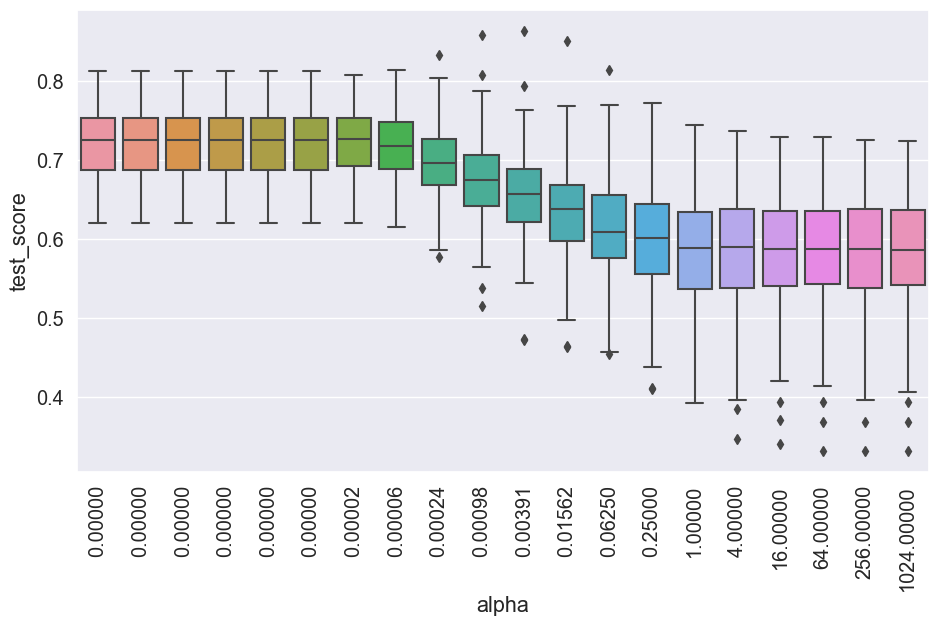

In [31]:
plot_performance(gcvS2)

In [32]:
# Final model
modelS1= FastSurvivalSVM(rank_ratio=1, max_iter=1000, tol=1e-5, random_state=0)
modelS1.set_params(**gcvS2.best_params_)
modelS1.fit(df_X_std_nonan, y_nonan)

FastSurvivalSVM(alpha=9.5367431640625e-07, max_iter=1000, optimizer='avltree',
                random_state=0, rank_ratio=1, tol=1e-05)

#### 3.2.1.2. Testing

In [33]:
def boots_ssvm (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_cindex= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        ssvm= FastSurvivalSVM(rank_ratio=1, max_iter=1000, tol=1e-5, random_state=0)
        ssvm.set_params(**params_)
        
        ssvm.fit(x.values[idx_train,], y[idx_train])
        
        cindex= ssvm.score(x.values[idx_test], y[idx_test])
        test_cindex.append(cindex)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    cindex_median= np.median(test_cindex)
    cindex_lower= max(0.0, np.percentile(test_cindex, pl))
    cindex_upper= min(1.0, np.percentile(test_cindex, pu))
    
    return (test_cindex, (cindex_median,cindex_lower,cindex_upper))

In [34]:
modelS1_cindex, modelS1_ci= boots_ssvm (x=df_X_std_nonan, y=y_nonan, train_size=0.8, params_=gcvS2.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'ModelS1: 0.73, 95%CI 0.62 and 0.82')

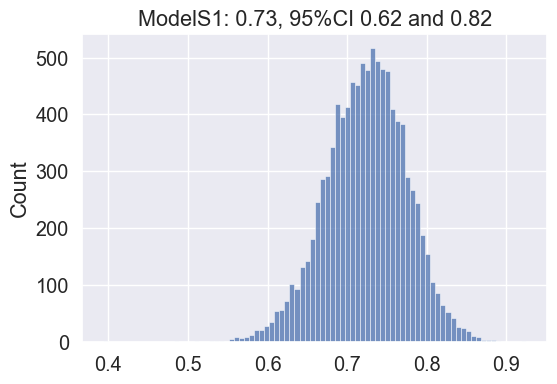

In [52]:
fig,ax= plt.subplots(1,1, figsize=(6,4))
sns.histplot(modelS1_cindex, ax=ax)

alpha= 0.05
ax.set_title('ModelS1: %.2f, %.0f%%CI %.2f and %.2f' % (modelS1_ci[0], (1-alpha)*100, modelS1_ci[1], modelS1_ci[2]))

#### 3.2.1.3. Predicting

Note that $r$ (*rank_ratio*) $=$ 1. This means that the SSVM objective is ranking, so the predictions denote **risk scores**, a higher predicted value indicates shorter survival, a lower value longer survival.

In [37]:
# Predict two patients
patients= [3,4]
pred= modelS1.predict(df_X_std_nonan.iloc[patients])
print('Patient %.f vs %.f:' % (1,2))
print('  · Preds:', pred)
print('  · Labels:', y[patients])

print('\n')
if pred[0] > pred[1]:
    print('Patient 1 have a higher risk than patient 2')
elif pred[0] < pred[1]:
    print('Patient 2 have a higher risk than patient 1')

Patient 1 vs 2:
  · Preds: [-0.01384484 -0.10587804]
  · Labels: [( True,    7.) (False, 1016.)]


Patient 1 have a higher risk than patient 2


### 3.2.2. Regression objective

- **Fitting**
- **Testing**
- **Prediction**

When the objective is **regression** ($r$ < 1) predictions will be on a **time scale**, so lower predicted values indicate shorter survival, higher values longer survival. Moreover, survival times are frequently positive skewed, therefore the survival/censoring times will be log-transformed by the FastSurvivalSVM internally, when using a $r$ < 1.

For regression, there can not be values equal to 0.

In [38]:
y_nonan['Survival_in_days'][y_nonan['Survival_in_days'] == 0] = 0.01

#### 3.2.2.1. Fitting

In [39]:
# Fit a model with the original variables and a regression objective

ssvm2= FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)


def score_survival_model_2 (model, X, y):
    prediction= model.predict(X)
    result= concordance_index_censored(y['Status'], y['Survival_in_days'], -prediction) # Invert to obtain risk scores
    return result[0]


gcvS3= GridSearchCV(estimator=ssvm2,
                    param_grid=param_gridS2, # we will use the same grid as for rank objective
                    scoring=score_survival_model_2,
                    n_jobs=1, refit=False,
                    cv=cv)


t0= time()
gcvS3.fit(df_X_std_nonan, y_nonan)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(gcvS3.best_params_, '\n')
print('Best score:', round(gcvS3.best_score_,4))

Fitting time: 4.20 min 

Best hyperparameters:
{'alpha': 0.0009765625} 

Best score: 0.7279


In [40]:
# Final model
modelS2= FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
modelS2.set_params(**gcvS3.best_params_)
modelS2.fit(df_X_std_nonan, y_nonan)

FastSurvivalSVM(alpha=0.0009765625, max_iter=1000, optimizer='avltree',
                random_state=0, rank_ratio=0.0, tol=1e-05)

#### 3.2.2.2. Testing

In [41]:
# Testing

def boots_ssvmr (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_cindex= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        ssvm= FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
        ssvm.set_params(**params_)
        
        ssvm.fit(x.values[idx_train,], y[idx_train])
        
        cindex= score_survival_model_2 (ssvm, x.values[idx_test], y[idx_test])
        test_cindex.append(cindex)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    cindex_median= np.median(test_cindex)
    cindex_lower= max(0.0, np.percentile(test_cindex, pl))
    cindex_upper= min(1.0, np.percentile(test_cindex, pu))
    
    return (test_cindex, (cindex_median,cindex_lower,cindex_upper))

In [42]:
modelS2_cindex, modelS2_ci= boots_ssvm (x=df_X_std_nonan, y=y_nonan, train_size=0.8, params_=gcvS3.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'ModelS2: 0.67, 95%CI 0.55 and 0.78')

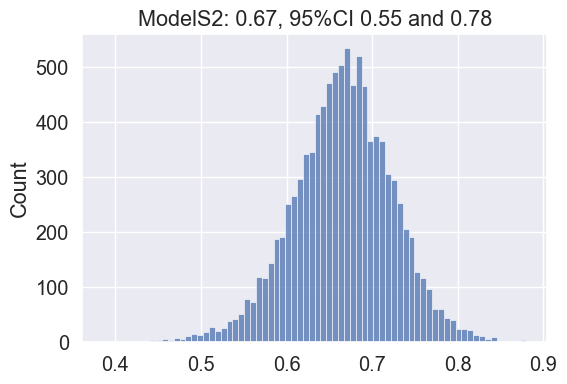

In [53]:
fig,ax= plt.subplots(1,1, figsize=(6,4))
sns.histplot(modelS2_cindex, ax=ax)

alpha= 0.05
ax.set_title('ModelS2: %.2f, %.0f%%CI %.2f and %.2f' % (modelS2_ci[0], (1-alpha)*100, modelS2_ci[1], modelS2_ci[2]))

#### 3.2.2.3. Predicting

Concordance_index_censored expects risk scores, therefore, **signs of predictions have to be flipped**, which are times of survival, to obtain the ranking for survival. The first in the ranking is "the most survivor", the last one to die.

In [44]:
# Predict the same two patients as modelS1
patients= [3,4]
pred= modelS2.predict(df_X_std_nonan.iloc[patients])
print('Patient %.f vs %.f:' % (1,2))
print('  · Preds:', -pred)
print('  · Labels:', y[patients])

print('\n')
if pred[0] < pred[1]: # Switch the sign
    print('Patient 1 have a higher risk than patient 2')
elif pred[0] > pred[1]: # Switch the sign
    print('Patient 2 have a higher risk than patient 1')

Patient 1 vs 2:
  · Preds: [  -4.45350369 -581.52428663]
  · Labels: [( True,    7.) (False, 1016.)]


Patient 1 have a higher risk than patient 2


### 3.3. Kernel SSVM

- Kernel SSVM fitting
- Kernel SSVM testing
- Kernel SSVM prediction

**Kernel SSVM** account for more complex relationships between features and survival time than Liner SSVM, however, the choice of kernel function and its hyperparameters is often not straightforward and requires tuning to obtain good results.

First of all, define the kernel matrix, which in this project is a **clinical kernel** due to it is able to distinguish between continuous, ordinal, and nominal attributes.

In [45]:
kernel_matrix= clinical_kernel(df_X_std_nonan)

#### 3.3.1. Fitting

Next step is fitting the model, taking care to fit it with the pre-computed square kernel matrix and not with the original data.

In [46]:
# Fit a model with clinical kernel and pre-computed variables
kssvm= FastKernelSurvivalSVM(optimizer='rbtree', kernel='precomputed', random_state=0)


kgcv= GridSearchCV(estimator=kssvm,
                   param_grid=param_gridS2,
                   scoring=score_survival_model,
                   n_jobs=1, refit=False,
                   cv=cv)



t0= time()
kgcv.fit(kernel_matrix, y_nonan)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(kgcv.best_params_, '\n')
print('Best score:', round(kgcv.best_score_,4))

Fitting time: 3.18 min 

Best hyperparameters:
{'alpha': 0.015625} 

Best score: 0.6131


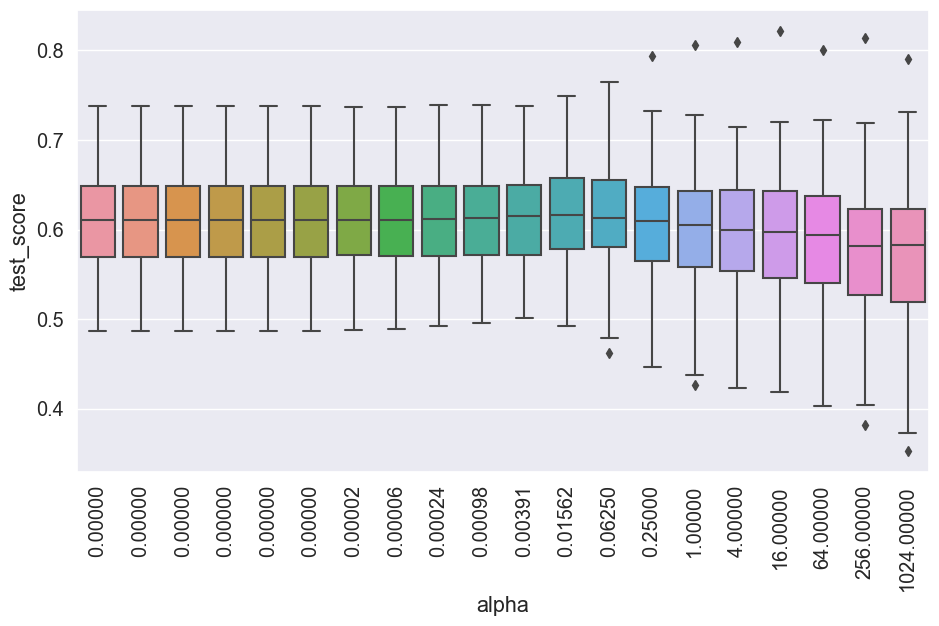

In [47]:
plot_performance(kgcv)

In [48]:
# Fit a model with different kernels
kssvm2= FastKernelSurvivalSVM(rank_ratio=1, optimizer='rbtree', random_state=0)

param_gridS3= {'alpha': 2. ** np.arange(-24, -16, 2),
               'kernel':['poly', 'rbf'],
               'gamma': [0.001, 0.005, 0.05, 0.1, 0.5],
               'degree': [1,2,3,4]}


kgcv2= GridSearchCV(estimator=kssvm2,
                    param_grid=param_gridS3,
                    scoring=score_survival_model,
                    n_jobs=1, refit=False,
                    cv=cv)



t0= time()
kgcv2.fit(df_X_std_nonan, y_nonan)
time_cv= time() - t0

print('Fitting time: %0.2f min'%(time_cv/60), '\n')
print('Best hyperparameters:')
print(kgcv2.best_params_, '\n')
print('Best score:', round(kgcv2.best_score_,4))

Fitting time: 9.68 min 

Best hyperparameters:
{'alpha': 3.814697265625e-06, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'} 

Best score: 0.7229


In [49]:
# Final model
modelS3= FastKernelSurvivalSVM(optimizer='rbtree', random_state=0)
modelS3.set_params(**kgcv2.best_params_)
modelS3.fit(df_X_std_nonan, y_nonan)

FastKernelSurvivalSVM(alpha=3.814697265625e-06, degree=2, gamma=0.001,
                      kernel='poly', optimizer='rbtree', random_state=0)

#### 3.3.2 Testing

In [50]:
# Testing

def boots_kssvm (x, y, train_size, n_iterations, params_, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    
    test_cindex= []

    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
        
        kssvm= FastKernelSurvivalSVM(optimizer='rbtree', random_state=0)
        kssvm.set_params(**params_)
        
        kssvm.fit(x.values[idx_train,], y[idx_train])
        
        cindex= kssvm.score (x.values[idx_test], y[idx_test])
        test_cindex.append(cindex)
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    cindex_median= np.median(test_cindex)
    cindex_lower= max(0.0, np.percentile(test_cindex, pl))
    cindex_upper= min(1.0, np.percentile(test_cindex, pu))
    
    return (test_cindex, (cindex_median,cindex_lower,cindex_upper))

In [54]:
modelS3_cindex, modelS3_ci= boots_kssvm (x=df_X_std_nonan, y=y_nonan, train_size=0.8, params_=kgcv2.best_params_, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'ModelS3: 0.72, 95%CI 0.61 and 0.81')

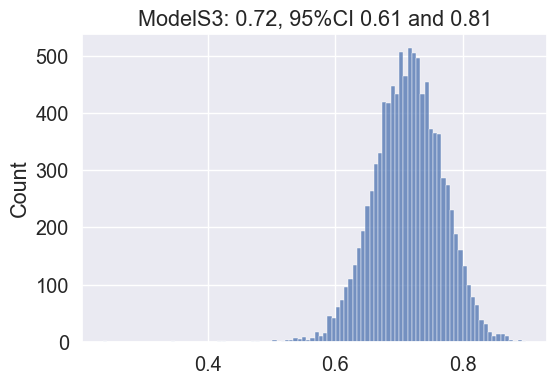

In [55]:
fig,ax= plt.subplots(1,1, figsize=(6,4))
sns.histplot(modelS3_cindex, ax=ax)

alpha= 0.05
ax.set_title('ModelS3: %.2f, %.0f%%CI %.2f and %.2f' % (modelS3_ci[0], (1-alpha)*100, modelS3_ci[1], modelS3_ci[2]))

#### 3.3.3 Predicting

In [56]:
# Predict two patients
patients= [3,4]
pred= modelS3.predict(df_X_std_nonan.iloc[patients])
print('Patient %.f vs %.f:' % (1,2))
print('  · Preds:', pred)
print('  · Labels:', y[patients])

print('\n')
if pred[0] > pred[1]:
    print('Patient 1 have a higher risk than patient 2')
elif pred[0] < pred[1]:
    print('Patient 2 have a higher risk than patient 1')

Patient 1 vs 2:
  · Preds: [-0.00081387 -0.00106006]
  · Labels: [( True,    7.) (False, 1016.)]


Patient 1 have a higher risk than patient 2
